In [ ]:
# !pip uninstall scikit-learn # Unistall scikit-learn 1.2.2

In [ ]:
# !pip install scikit-learn==0.24.1
# !pip install scikit-learn

In [ ]:
# Import libraries
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq
import zipfile
from pathlib import Path
import datetime
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from time import time
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_bicing_joined=dd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/CapstoneProject/data_bicing_joined_HX.csv',sep=';')

In [ ]:
data_bicing_joined.head()

,station_id,name,year,month,day,hour,last_updated_formated,last_update_formated_H-1,last_update_formated_H-2,last_update_formated_H-3,last_update_formated_H-4,H-1,H-2,H-3,H-4,lat,lon,post_code,capacity,num_docks_available,num_bikes_available,is_installed,is_renting,is_returning,% Docks Availlable,% Docks Available H-4,% Docks Available H-3,% Docks Available H-2,% Docks Available H-1,status,ttl
0,290,"PL. DELS JARDINS D'ALFÀBIA, 1",2019,7,22,8,2019-07-22 08:59:55,2019-07-22 07:59:55,2019-07-22 06:59:55,2019-07-22 05:59:55,2019-07-22 04:59:55,2019072207,2019072206,2019072205,2019072204,41.437338,2.174096,8016,17,12.769231,2.230769,1,1,1,0.751131,0.352941,0.352941,0.352941,0.504902,IN_SERVICE,30
1,271,"VIA BARCINO, 69",2022,6,10,21,2022-06-10 21:59:45,2022-06-10 20:59:45,2022-06-10 19:59:45,2022-06-10 18:59:45,2022-06-10 17:59:45,2022061020,2022061019,2022061018,2022061017,41.450608,2.192363,8033,21,16.153846,3.846154,1,1,1,0.769231,0.753968,0.659341,0.645022,0.686508,IN_SERVICE,29
2,149,"C/ PUJADES, 57B",2022,6,8,20,2022-06-08 20:59:39,2022-06-08 19:59:39,2022-06-08 18:59:39,2022-06-08 17:59:39,2022-06-08 16:59:39,2022060819,2022060818,2022060817,2022060816,41.395868,2.192952,8019,27,19.846154,4.692308,1,1,1,0.735043,0.491582,0.675214,0.864198,0.801347,IN_SERVICE,30
3,342,"C/ ROC BORONAT, 134",2020,2,4,4,2020-02-04 04:55:16,2020-02-04 03:55:16,2020-02-04 02:55:16,2020-02-04 01:55:16,2020-02-04 00:55:16,2020020403,2020020402,2020020401,2020020400,41.403497,2.193658,8018,27,21.000000,5.000000,1,1,1,0.777778,0.898990,0.831909,0.777778,0.777778,IN_SERVICE,30
4,358,"C/ GOMBAU, 24",2021,5,28,8,2021-05-28 08:59:30,2021-05-28 07:59:30,2021-05-28 06:59:30,2021-05-28 05:59:30,2021-05-28 04:59:30,2021052807,2021052806,2021052805,2021052804,41.387244,2.179304,8003,25,23.583333,2.416667,1,1,1,0.943333,0.480000,0.480000,0.513333,0.766667,IN_SERVICE,30


In [ ]:
weather=dd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/CapstoneProject/weather.csv', dtype={'mm_precip': 'float64'})

In [ ]:
weather.head()

,timestamp,mm_precip,temperature
0,1546297200,0.0,9.1
1,1546299000,0.0,8.9
2,1546300800,0.0,9.0
3,1546302600,0.0,9.2
4,1546304400,0.0,8.6


In [ ]:
import pandas as pd


In [ ]:
# Convertir la columna 'timestamp' en objetos de fecha y hora 
weather['datetime'] = weather['timestamp'].map(lambda x: pd.to_datetime(x, unit='s'))

In [ ]:
weather.head()

,timestamp,mm_precip,temperature,datetime
0,1546297200,0.0,9.1,2018-12-31 23:00:00
1,1546299000,0.0,8.9,2018-12-31 23:30:00
2,1546300800,0.0,9.0,2019-01-01 00:00:00
3,1546302600,0.0,9.2,2019-01-01 00:30:00
4,1546304400,0.0,8.6,2019-01-01 01:00:00


In [ ]:
# Función personalizada para filtrar filas con minutos diferentes de 0 
def filter_hours(df):
    return df[df['datetime'].dt.minute == 0]

In [ ]:
# Aplicar la función personalizada 
weather_hour = weather.map_partitions(filter_hours)


In [ ]:
weather_hour.shape[0].compute()

37224

In [ ]:
weather_hour = weather_hour.drop_duplicates(subset=['timestamp'])

In [ ]:
weather_hour.shape[0].compute() #37219

37219

In [ ]:
weather_hour.head()

,timestamp,mm_precip,temperature,datetime
0,1546297200,0.0,9.1,2018-12-31 23:00:00
2,1546300800,0.0,9.0,2019-01-01 00:00:00
4,1546304400,0.0,8.6,2019-01-01 01:00:00
6,1546308000,0.0,7.7,2019-01-01 02:00:00
8,1546311600,0.0,7.3,2019-01-01 03:00:00


In [ ]:
# DataFrame de estaciones
data_bicing_joined['datetime'] = dd.to_datetime(data_bicing_joined['year'].astype(str) + '-' +
                                                data_bicing_joined['month'].astype(str) + '-' +
                                                data_bicing_joined['day'].astype(str) + ' ' +
                                                data_bicing_joined['hour'].astype(str) + ':00:00')

In [ ]:
data_bicing_joined.head()

,station_id,name,year,month,day,hour,last_updated_formated,last_update_formated_H-1,last_update_formated_H-2,last_update_formated_H-3,last_update_formated_H-4,H-1,H-2,H-3,H-4,lat,lon,post_code,capacity,num_docks_available,num_bikes_available,is_installed,is_renting,is_returning,% Docks Availlable,% Docks Available H-4,% Docks Available H-3,% Docks Available H-2,% Docks Available H-1,status,ttl,datetime
0,290,"PL. DELS JARDINS D'ALFÀBIA, 1",2019,7,22,8,2019-07-22 08:59:55,2019-07-22 07:59:55,2019-07-22 06:59:55,2019-07-22 05:59:55,2019-07-22 04:59:55,2019072207,2019072206,2019072205,2019072204,41.437338,2.174096,8016,17,12.769231,2.230769,1,1,1,0.751131,0.352941,0.352941,0.352941,0.504902,IN_SERVICE,30,2019-07-22 08:00:00
1,271,"VIA BARCINO, 69",2022,6,10,21,2022-06-10 21:59:45,2022-06-10 20:59:45,2022-06-10 19:59:45,2022-06-10 18:59:45,2022-06-10 17:59:45,2022061020,2022061019,2022061018,2022061017,41.450608,2.192363,8033,21,16.153846,3.846154,1,1,1,0.769231,0.753968,0.659341,0.645022,0.686508,IN_SERVICE,29,2022-06-10 21:00:00
2,149,"C/ PUJADES, 57B",2022,6,8,20,2022-06-08 20:59:39,2022-06-08 19:59:39,2022-06-08 18:59:39,2022-06-08 17:59:39,2022-06-08 16:59:39,2022060819,2022060818,2022060817,2022060816,41.395868,2.192952,8019,27,19.846154,4.692308,1,1,1,0.735043,0.491582,0.675214,0.864198,0.801347,IN_SERVICE,30,2022-06-08 20:00:00
3,342,"C/ ROC BORONAT, 134",2020,2,4,4,2020-02-04 04:55:16,2020-02-04 03:55:16,2020-02-04 02:55:16,2020-02-04 01:55:16,2020-02-04 00:55:16,2020020403,2020020402,2020020401,2020020400,41.403497,2.193658,8018,27,21.000000,5.000000,1,1,1,0.777778,0.898990,0.831909,0.777778,0.777778,IN_SERVICE,30,2020-02-04 04:00:00
4,358,"C/ GOMBAU, 24",2021,5,28,8,2021-05-28 08:59:30,2021-05-28 07:59:30,2021-05-28 06:59:30,2021-05-28 05:59:30,2021-05-28 04:59:30,2021052807,2021052806,2021052805,2021052804,41.387244,2.179304,8003,25,23.583333,2.416667,1,1,1,0.943333,0.480000,0.480000,0.513333,0.766667,IN_SERVICE,30,2021-05-28 08:00:00


In [ ]:
def merge_temperature_rain(df_stations, df_weather, hours_difference):
    df_weather_shifted = df_weather.copy()
    df_weather_shifted['datetime'] = df_weather_shifted['datetime'] + pd.Timedelta(hours=hours_difference)
    df_stations = df_stations.merge(df_weather_shifted[['datetime', 'temperature','mm_precip']], on='datetime', how='left', suffixes=('', f'_H-{abs(hours_difference)}'))
    return df_stations


In [ ]:
# data_bicing_joined.shape[0].compute()

In [ ]:
data_bicing_joined_climate = merge_temperature_rain(data_bicing_joined, weather_hour, 0)


In [ ]:
for i in range(1, 5):
    data_bicing_joined_climate = merge_temperature_rain(data_bicing_joined_climate, weather_hour, i)

In [ ]:
# data_bicing_joined_climate.shape[0].compute()

In [ ]:
data_bicing_joined_climate.head()

,station_id,name,year,month,day,hour,last_updated_formated,last_update_formated_H-1,last_update_formated_H-2,last_update_formated_H-3,last_update_formated_H-4,H-1,H-2,H-3,H-4,lat,lon,post_code,capacity,num_docks_available,num_bikes_available,is_installed,is_renting,is_returning,% Docks Availlable,% Docks Available H-4,% Docks Available H-3,% Docks Available H-2,% Docks Available H-1,status,ttl,datetime,temperature,mm_precip,temperature_H-1,mm_precip_H-1,temperature_H-2,mm_precip_H-2,temperature_H-3,mm_precip_H-3,temperature_H-4,mm_precip_H-4
0,290,"PL. DELS JARDINS D'ALFÀBIA, 1",2019,7,22,8,2019-07-22 08:59:55,2019-07-22 07:59:55,2019-07-22 06:59:55,2019-07-22 05:59:55,2019-07-22 04:59:55,2019072207,2019072206,2019072205,2019072204,41.437338,2.174096,8016,17,12.769231,2.230769,1,1,1,0.751131,0.352941,0.352941,0.352941,0.504902,IN_SERVICE,30,2019-07-22 08:00:00,30.8,0.0,30.0,0.0,29.4,0.0,27.1,0.0,25.9,0.0
1,271,"VIA BARCINO, 69",2022,6,10,21,2022-06-10 21:59:45,2022-06-10 20:59:45,2022-06-10 19:59:45,2022-06-10 18:59:45,2022-06-10 17:59:45,2022061020,2022061019,2022061018,2022061017,41.450608,2.192363,8033,21,16.153846,3.846154,1,1,1,0.769231,0.753968,0.659341,0.645022,0.686508,IN_SERVICE,29,2022-06-10 21:00:00,21.1,0.0,21.6,0.0,22.7,0.0,22.8,0.0,23.4,0.0
2,149,"C/ PUJADES, 57B",2022,6,8,20,2022-06-08 20:59:39,2022-06-08 19:59:39,2022-06-08 18:59:39,2022-06-08 17:59:39,2022-06-08 16:59:39,2022060819,2022060818,2022060817,2022060816,41.395868,2.192952,8019,27,19.846154,4.692308,1,1,1,0.735043,0.491582,0.675214,0.864198,0.801347,IN_SERVICE,30,2022-06-08 20:00:00,20.8,0.0,21.4,0.0,21.7,0.0,22.5,0.0,23.2,0.0
3,342,"C/ ROC BORONAT, 134",2020,2,4,4,2020-02-04 04:55:16,2020-02-04 03:55:16,2020-02-04 02:55:16,2020-02-04 01:55:16,2020-02-04 00:55:16,2020020403,2020020402,2020020401,2020020400,41.403497,2.193658,8018,27,21.000000,5.000000,1,1,1,0.777778,0.898990,0.831909,0.777778,0.777778,IN_SERVICE,30,2020-02-04 04:00:00,16.8,0.0,16.7,0.0,17.1,0.0,18.8,0.0,18.0,0.0
4,358,"C/ GOMBAU, 24",2021,5,28,8,2021-05-28 08:59:30,2021-05-28 07:59:30,2021-05-28 06:59:30,2021-05-28 05:59:30,2021-05-28 04:59:30,2021052807,2021052806,2021052805,2021052804,41.387244,2.179304,8003,25,23.583333,2.416667,1,1,1,0.943333,0.480000,0.480000,0.513333,0.766667,IN_SERVICE,30,2021-05-28 08:00:00,23.5,0.0,22.7,0.0,23.2,0.0,22.2,0.0,19.4,0.0


In [ ]:
#Funcion para saber si es fin de semana o no
def is_weekend(day_of_week):
    return 1 if day_of_week >= 5 else 0

data_bicing_joined_climate['day_of_week'] = data_bicing_joined_climate['datetime'].dt.dayofweek
data_bicing_joined_climate['number_of_week'] = data_bicing_joined_climate['datetime'].dt.isocalendar().week
data_bicing_joined_climate['is_weekend'] = data_bicing_joined_climate['day_of_week'].map(is_weekend, meta=('is_weekend', 'int64'))
# data_bicing_joined_climate = data_bicing_joined_climate.drop('day_of_week', axis=1)

In [ ]:
data_bicing_joined_climate.head()

,station_id,name,year,month,day,hour,last_updated_formated,last_update_formated_H-1,last_update_formated_H-2,last_update_formated_H-3,last_update_formated_H-4,H-1,H-2,H-3,H-4,lat,lon,post_code,capacity,num_docks_available,num_bikes_available,is_installed,is_renting,is_returning,% Docks Availlable,% Docks Available H-4,% Docks Available H-3,% Docks Available H-2,% Docks Available H-1,status,ttl,datetime,temperature,mm_precip,temperature_H-1,mm_precip_H-1,temperature_H-2,mm_precip_H-2,temperature_H-3,mm_precip_H-3,temperature_H-4,mm_precip_H-4,day_of_week,number_of_week,is_weekend
0,290,"PL. DELS JARDINS D'ALFÀBIA, 1",2019,7,22,8,2019-07-22 08:59:55,2019-07-22 07:59:55,2019-07-22 06:59:55,2019-07-22 05:59:55,2019-07-22 04:59:55,2019072207,2019072206,2019072205,2019072204,41.437338,2.174096,8016,17,12.769231,2.230769,1,1,1,0.751131,0.352941,0.352941,0.352941,0.504902,IN_SERVICE,30,2019-07-22 08:00:00,30.8,0.0,30.0,0.0,29.4,0.0,27.1,0.0,25.9,0.0,0,30,0
1,271,"VIA BARCINO, 69",2022,6,10,21,2022-06-10 21:59:45,2022-06-10 20:59:45,2022-06-10 19:59:45,2022-06-10 18:59:45,2022-06-10 17:59:45,2022061020,2022061019,2022061018,2022061017,41.450608,2.192363,8033,21,16.153846,3.846154,1,1,1,0.769231,0.753968,0.659341,0.645022,0.686508,IN_SERVICE,29,2022-06-10 21:00:00,21.1,0.0,21.6,0.0,22.7,0.0,22.8,0.0,23.4,0.0,4,23,0
2,149,"C/ PUJADES, 57B",2022,6,8,20,2022-06-08 20:59:39,2022-06-08 19:59:39,2022-06-08 18:59:39,2022-06-08 17:59:39,2022-06-08 16:59:39,2022060819,2022060818,2022060817,2022060816,41.395868,2.192952,8019,27,19.846154,4.692308,1,1,1,0.735043,0.491582,0.675214,0.864198,0.801347,IN_SERVICE,30,2022-06-08 20:00:00,20.8,0.0,21.4,0.0,21.7,0.0,22.5,0.0,23.2,0.0,2,23,0
3,342,"C/ ROC BORONAT, 134",2020,2,4,4,2020-02-04 04:55:16,2020-02-04 03:55:16,2020-02-04 02:55:16,2020-02-04 01:55:16,2020-02-04 00:55:16,2020020403,2020020402,2020020401,2020020400,41.403497,2.193658,8018,27,21.000000,5.000000,1,1,1,0.777778,0.898990,0.831909,0.777778,0.777778,IN_SERVICE,30,2020-02-04 04:00:00,16.8,0.0,16.7,0.0,17.1,0.0,18.8,0.0,18.0,0.0,1,6,0
4,358,"C/ GOMBAU, 24",2021,5,28,8,2021-05-28 08:59:30,2021-05-28 07:59:30,2021-05-28 06:59:30,2021-05-28 05:59:30,2021-05-28 04:59:30,2021052807,2021052806,2021052805,2021052804,41.387244,2.179304,8003,25,23.583333,2.416667,1,1,1,0.943333,0.480000,0.480000,0.513333,0.766667,IN_SERVICE,30,2021-05-28 08:00:00,23.5,0.0,22.7,0.0,23.2,0.0,22.2,0.0,19.4,0.0,4,21,0


In [ ]:
data_bicing_joined_climate.columns

Index(['station_id', 'name', 'year', 'month', 'day', 'hour',
       'last_updated_formated', 'last_update_formated_H-1',
       'last_update_formated_H-2', 'last_update_formated_H-3',
       'last_update_formated_H-4', 'H-1', 'H-2', 'H-3', 'H-4', 'lat', 'lon',
       'post_code', 'capacity', 'num_docks_available', 'num_bikes_available',
       'is_installed', 'is_renting', 'is_returning', '% Docks Availlable',
       '% Docks Available H-4', '% Docks Available H-3',
       '% Docks Available H-2', '% Docks Available H-1', 'status', 'ttl',
       'datetime', 'temperature', 'mm_precip', 'temperature_H-1',
       'mm_precip_H-1', 'temperature_H-2', 'mm_precip_H-2', 'temperature_H-3',
       'mm_precip_H-3', 'temperature_H-4', 'mm_precip_H-4', 'day_of_week',
       'number_of_week', 'is_weekend'],
      dtype='object')

In [ ]:
# data_bicing_joined_climate.size.compute()

In [ ]:
# data_bicing_joined_climate.dropna().size.compute()

In [ ]:
data_bicing_joined_climate_cleaned = data_bicing_joined_climate.dropna() #default axis=0

In [ ]:
#Funcion para saber si el status esta IN_SERVICE o no
def is_inservice(status):
    return 1 if status == "IN_SERVICE" else 0

data_bicing_joined_climate_cleaned['is_inservice'] = data_bicing_joined_climate_cleaned['status'].map(is_inservice, meta=('is_inservice', 'int64'))

In [ ]:
# Nosotros definimos las horas tanto para Train y Test. Se debe analizar si para el Test del 2023, usaremos las horas del archivo para filtrarlo en el Train por station_id
# data_bicing_joined_climate_cleaned = data_bicing_joined_climate_cleaned[data_bicing_joined_climate_cleaned.month.isin([3])]
# data = data_bicing_joined_climate_cleaned[data_bicing_joined_climate_cleaned.hour.isin([0,5,10,15,20])]
data = data_bicing_joined_climate_cleaned[data_bicing_joined_climate_cleaned.hour.isin([4,9,14,19,23])]
data_w20=data[~data.year.isin([2020])]

In [ ]:
data_w20.npartitions

72

In [ ]:
data.npartitions

72

In [ ]:
# data_10porct = data.partitions[::8] # 10% 72 partitions
dataw20_10porct = data_w20.partitions[::8] # 30% 72 partitions

In [ ]:
dataw20_10porct.head()

,station_id,name,year,month,day,hour,last_updated_formated,last_update_formated_H-1,last_update_formated_H-2,last_update_formated_H-3,last_update_formated_H-4,H-1,H-2,H-3,H-4,lat,lon,post_code,capacity,num_docks_available,num_bikes_available,is_installed,is_renting,is_returning,% Docks Availlable,% Docks Available H-4,% Docks Available H-3,% Docks Available H-2,% Docks Available H-1,status,ttl,datetime,temperature,mm_precip,temperature_H-1,mm_precip_H-1,temperature_H-2,mm_precip_H-2,temperature_H-3,mm_precip_H-3,temperature_H-4,mm_precip_H-4,day_of_week,number_of_week,is_weekend,is_inservice
17,237,"C/ RIUS I TAULET, 4",2021,5,7,23,2021-05-07 23:59:40,2021-05-07 22:59:40,2021-05-07 21:59:40,2021-05-07 20:59:40,2021-05-07 19:59:40,2021050722,2021050721,2021050720,2021050719,41.372743,2.153920,8004,27,19.769231,5.230769,1,1,1,0.732194,0.749288,0.814815,0.831909,0.882155,IN_SERVICE,30,2021-05-07 23:00:00,15.0,0.0,15.0,0.0,16.0,0.0,15.8,0.0,16.4,0.0,4,18,0,1
18,13,"CARRER DE LA MARINA, 25-33",2021,6,7,9,2021-06-07 09:59:55,2021-06-07 08:59:55,2021-06-07 07:59:55,2021-06-07 06:59:55,2021-06-07 05:59:55,2021060708,2021060707,2021060706,2021060705,41.388125,2.195187,8005,54,6.583333,43.416667,1,1,1,0.121914,0.768519,0.749158,0.691358,0.471510,IN_SERVICE,30,2021-06-07 09:00:00,25.1,0.0,25.0,0.0,24.9,0.0,23.9,0.0,22.3,0.0,0,23,0,1
28,159,"AV. DIAGONAL, 26",2022,11,10,14,2022-11-10 14:59:43,2022-11-10 13:59:43,2022-11-10 12:59:43,2022-11-10 11:59:43,2022-11-10 10:59:43,2022111013,2022111012,2022111011,2022111010,41.411082,2.216314,8019,32,3.916667,27.083333,1,1,1,0.122396,0.033854,0.045455,0.170673,0.190104,IN_SERVICE,9,2022-11-10 14:00:00,18.0,0.0,19.7,0.0,20.5,0.0,20.6,0.0,20.3,0.0,3,45,0,1
31,263,"PG. TORRAS I BAGES, 29",2021,8,24,23,2021-08-24 23:59:44,2021-08-24 22:59:44,2021-08-24 21:59:44,2021-08-24 20:59:44,2021-08-24 19:59:44,2021082422,2021082421,2021082420,2021082419,41.437877,2.191069,8030,20,17.153846,2.846154,1,1,1,0.857692,0.572727,0.870833,0.880769,0.890909,IN_SERVICE,30,2021-08-24 23:00:00,21.9,0.0,21.4,0.0,21.8,0.0,22.0,0.0,22.5,0.0,1,34,0,1
33,212,"AV. SARRIÀ, 163",2021,5,1,23,2021-05-01 23:55:01,2021-05-01 22:55:01,2021-05-01 21:55:01,2021-05-01 20:55:01,2021-05-01 19:55:01,2021050122,2021050121,2021050120,2021050119,41.392235,2.130927,8017,24,0.083333,22.916667,1,1,1,0.003472,0.680556,0.787879,0.516026,0.049242,IN_SERVICE,30,2021-05-01 23:00:00,12.6,0.0,13.7,0.0,13.0,0.0,13.6,0.0,13.8,0.0,5,17,1,1


In [ ]:
# Cálculo de correlación con Pandas
# ==============================================================================
columns = ["% Docks Availlable", "% Docks Available H-1", "% Docks Available H-2", "% Docks Available H-3", "% Docks Available H-4",
           "lat","lon","year","hour","month","day","temperature","temperature_H-1","temperature_H-2","temperature_H-3","temperature_H-4","number_of_week","mm_precip", "mm_precip_H-1",
           "mm_precip_H-2","mm_precip_H-3","mm_precip_H-4","day_of_week","ttl","is_weekend","capacity","is_inservice","is_returning","is_renting","is_installed","num_bikes_available"]
df = dataw20_10porct[columns]
print('Correlación Pearson: \n', df.corr(method='pearson')["% Docks Availlable"].compute().sort_values(ascending=False))
# print('Correlación Pearson: ', dataw20_10porct.corr(method='spearman')["% Docks Availlable"].compute())
# print('Correlación Pearson: ', dataw20_10porct.corr(method='kendall')["% Docks Availlable"].compute())

Correlación Pearson: 
 % Docks Availlable       1.000000
% Docks Available H-1    0.914294
% Docks Available H-2    0.773755
% Docks Available H-3    0.664688
% Docks Available H-4    0.598391
lat                      0.133158
year                     0.063143
temperature_H-4          0.031205
temperature_H-2          0.031176
temperature_H-3          0.030707
temperature_H-1          0.030333
month                    0.029773
number_of_week           0.026681
hour                     0.026320
temperature              0.025936
day                      0.000257
mm_precip               -0.000800
mm_precip_H-3           -0.004859
mm_precip_H-4           -0.005101
mm_precip_H-1           -0.005901
mm_precip_H-2           -0.006086
ttl                     -0.012668
day_of_week             -0.017589
is_weekend              -0.021176
capacity                -0.039441
is_inservice            -0.049306
is_returning            -0.060145
is_renting              -0.060145
is_installed            -

In [ ]:
# data_10porct = data_10porct.categorize(columns=["station_id","month","day_of_week","number_of_week","hour","post_code"])
dataw20_10porct = dataw20_10porct.categorize(columns=["station_id","month","day_of_week","number_of_week","hour","post_code"])

In [ ]:
num_pipeline = Pipeline([
     ('imputer', SimpleImputer(strategy="median")),
      ('std_scaler', StandardScaler()),
])

num_pipeline1 = Pipeline([
     ('imputer', SimpleImputer(strategy="median")),
])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

# cat_attribs = ["month","day_of_week","number_of_week","hour"] #"station_id"
# num_attribs = ['lat', 'lon',"capacity",'% Docks Available H-4', '% Docks Available H-3', '% Docks Available H-2', '% Docks Available H-1','temperature','mm_precip'
#                  ,'temperature_H-1', 'mm_precip_H-1', 'temperature_H-2', 'mm_precip_H-2', 'temperature_H-3','mm_precip_H-3', 'temperature_H-4', 'mm_precip_H-4']
# num_attribs1 = ['is_installed', 'is_renting', 'is_returning','is_inservice',"is_weekend"]

num_attribs = ['lat', 'lon', 'temperature', 'temperature_H-1', 'temperature_H-2','temperature_H-3','temperature_H-4'] #, 'num_bikes_available' (after of temperatura)
num_attribs1 = ['% Docks Available H-1', '% Docks Available H-2', '% Docks Available H-3', '% Docks Available H-4']
cat_attribs = ["month","day_of_week","number_of_week","hour"] #"station_id", "year"

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("num1", num_pipeline1, num_attribs1),
        ("cat", cat_pipeline, cat_attribs),
    ])

# **Años : 2019 , 2020, 2021, 2022**

In [ ]:
X = data_10porct.loc[:,~data_10porct.columns.isin(["% Docks Availlable"])].compute()
y = data_10porct.loc[:,data_10porct.columns.isin(["% Docks Availlable"])].compute()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=X["station_id"])

KeyboardInterrupt: ignored

In [ ]:
bicing_num_tr = full_pipeline.fit_transform(X_train)
bicing_num_tt = full_pipeline.transform(X_test)
print("bicing_num_tr", bicing_num_tr.shape)
print("bicing_num_tt", bicing_num_tt.shape)

In [ ]:
t0 = time()
base_model = GradientBoostingRegressor(random_state=0)
base_model.fit(bicing_num_tr,y_train)

print("training time:", round(time()-t0, 3), "s")
pred = base_model.predict(bicing_num_tr)
forest_mse = mean_squared_error(y_train,pred)
forest_rmse = np.sqrt(forest_mse)
forest_r2score=r2_score(y_train,pred)
print("RMSE:",forest_rmse)
print("R2 score:",forest_r2score)
print("")
t1 = time()
pred = base_model.predict(bicing_num_tt)
print("testing time:", round(time()-t1, 3), "s")
forest_mse = mean_squared_error(y_test,pred)
forest_rmse = np.sqrt(forest_mse)
forest_r2score=r2_score(y_test,pred)
print("RMSE:",forest_rmse)
print("R2 score:",forest_r2score)
plt.scatter(y_test,pred)
plt.ylabel("Predicted docks available")
plt.xlabel("Real docks available")
plt.show()

# **Años : 2019, 2021, 2022 (sin COVID)**

In [ ]:
X = dataw20_10porct.loc[:,~dataw20_10porct.columns.isin(["% Docks Availlable"])].compute()
y = dataw20_10porct.loc[:,dataw20_10porct.columns.isin(["% Docks Availlable"])].compute()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=X["station_id"])

In [ ]:
bicing_num_tr = full_pipeline.fit_transform(X_train)
bicing_num_tt = full_pipeline.transform(X_test)
print("bicing_num_tr", bicing_num_tr.shape)
print("bicing_num_tt", bicing_num_tt.shape)

bicing_num_tr (237038, 88)
bicing_num_tt (59260, 88)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training time: 88.75 s
RMSE: 0.10243046726616038
R2 score: 0.8768820610674999

testing time: 0.173 s
RMSE: 0.10253929318906654
R2 score: 0.8773760556366937


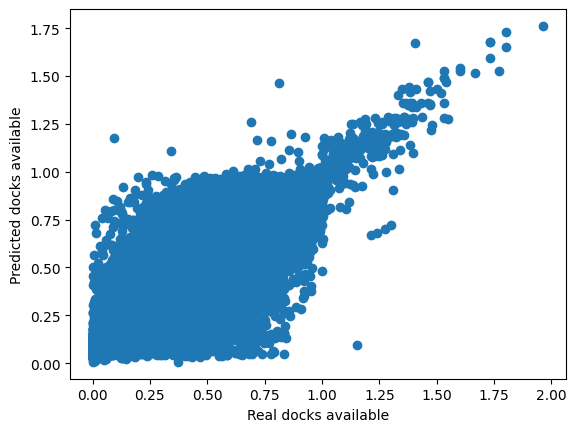

In [ ]:
t0 = time()
base_model = GradientBoostingRegressor(random_state=0)
base_model.fit(bicing_num_tr,y_train)

print("training time:", round(time()-t0, 3), "s")
pred = base_model.predict(bicing_num_tr)
forest_mse = mean_squared_error(y_train,pred)
forest_rmse = np.sqrt(forest_mse)
forest_r2score=r2_score(y_train,pred)
print("RMSE:",forest_rmse)
print("R2 score:",forest_r2score)
print("")
t1 = time()
pred = base_model.predict(bicing_num_tt)
print("testing time:", round(time()-t1, 3), "s")
forest_mse = mean_squared_error(y_test,pred)
forest_rmse = np.sqrt(forest_mse)
forest_r2score=r2_score(y_test,pred)
print("RMSE:",forest_rmse)
print("R2 score:",forest_r2score)
plt.scatter(y_test,pred)
plt.ylabel("Predicted docks available")
plt.xlabel("Real docks available")
plt.show()

####### First Iteration #################
# training time: 59.88 s
# RMSE: 0.10242090153564459
# R2 score: 0.8769050553594337

# testing time: 0.175 s
# RMSE: 0.10251650627957275
# R2 score: 0.8774305500682559

training time: 35.715 s
RMSE: 0.0984245108001696
R2 score: 0.8851045113641223

testing time: 0.217 s
RMSE: 0.10398873890069375
R2 score: 0.8713388220182984


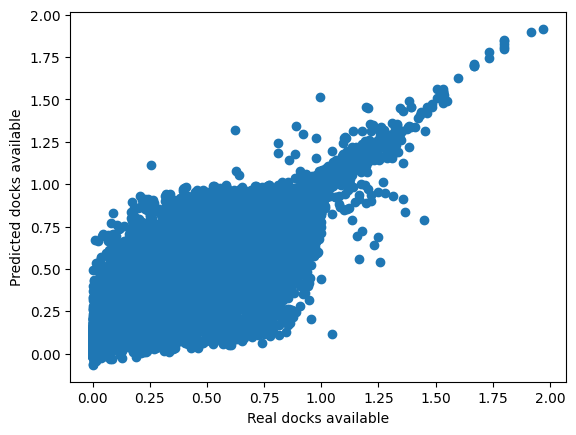

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

t0 = time()
xgb_model = XGBRegressor(objective='reg:squarederror', random_state = 69)
# xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_alpha=0.1, reg_lambda=0.1, n_jobs=-1, random_state=123)
xgb_model.fit(bicing_num_tr,y_train)

print("training time:", round(time()-t0, 3), "s")
pred = xgb_model.predict(bicing_num_tr)
forest_mse = mean_squared_error(y_train,pred)
forest_rmse = np.sqrt(forest_mse)
forest_r2score=r2_score(y_train,pred)
print("RMSE:",forest_rmse)
print("R2 score:",forest_r2score)
print("")
t1 = time()
pred = xgb_model.predict(bicing_num_tt)
print("testing time:", round(time()-t1, 3), "s")
forest_mse = mean_squared_error(y_test,pred)
forest_rmse = np.sqrt(forest_mse)
forest_r2score=r2_score(y_test,pred)
print("RMSE:",forest_rmse)
print("R2 score:",forest_r2score)
plt.scatter(y_test,pred)
plt.ylabel("Predicted docks available")
plt.xlabel("Real docks available")
plt.show()

####### First Iteration #################
# training time: 41.922 s
# RMSE: 0.093513259627878
# R2 score: 0.897385337748149

# testing time: 0.235 s
# RMSE: 0.0984160377261741
# R2 score: 0.8870395548876768


####### Second Iteration with diferent features (included num_bikes_available ) and best parameters #################
# training time: 300.951 s
# RMSE: 0.05178672264529328
# R2 score: 0.9685297724349945

# testing time: 1.636 s
# RMSE: 0.05501272295627215
# R2 score: 0.9647043709792963

####### Third Iteration with diferent features (included num_bikes_available ) #################
# training time: 42.862 s
# RMSE: 0.0532172706034097
# R2 score: 0.9667671014084683

# testing time: 0.43 s
# RMSE: 0.05709249084398604
# R2 score: 0.9619852074775715

####### Fourth Iteration with diferent features and best parameters #################
# training time: 301.189 s
# RMSE: 0.08995319657201532
# R2 score: 0.9050497241440011

# testing time: 1.84 s
# RMSE: 0.09807910533202138
# R2 score: 0.8878116827613083


####### Fourth Iteration with diferent features and new range of hours #################
# training time: 35.715 s
# RMSE: 0.0984245108001696
# R2 score: 0.8851045113641223

# testing time: 0.217 s
# RMSE: 0.10398873890069375
# R2 score: 0.8713388220182984

In [ ]:
X_test["% Docks Availlable"] = y_test
X_test["% Docks Availlable_PRED"] = pred

In [ ]:
columns = ["station_id","year", "month","hour","post_code",'lat', 'lon',"capacity","% Docks Availlable","% Docks Availlable_PRED",
           '% Docks Available H-1', '% Docks Available H-2', '% Docks Available H-3','% Docks Available H-4','day_of_week','number_of_week','is_installed', 
               'is_renting', 'is_returning','is_inservice',"is_weekend"]

X_test[columns]

,station_id,year,month,hour,post_code,lat,lon,capacity,% Docks Availlable,% Docks Availlable_PRED,% Docks Available H-1,% Docks Available H-2,% Docks Available H-3,% Docks Available H-4,day_of_week,number_of_week,is_installed,is_renting,is_returning,is_inservice,is_weekend
86946,227,2021,6,5,8024,41.407846,2.158670,18,0.111111,0.148390,0.111111,0.162037,0.217593,0.351852,1,25,1,1,1,1,0
199007,369,2019,5,10,8013,41.400130,2.178018,27,0.694444,0.739075,0.746914,0.663580,0.324074,0.086420,4,21,1,1,1,1,0
87285,75,2019,11,0,8029,41.385004,2.142911,21,0.734127,0.801057,0.813492,0.876984,0.837302,0.682540,1,47,1,1,1,1,0
157129,182,2021,9,20,8014,41.371477,2.143930,33,0.638889,0.635105,0.684343,0.823232,0.841492,0.866162,1,39,1,1,1,1,0
52139,122,2022,6,10,8025,41.405446,2.166317,25,0.960000,0.892628,0.941538,0.945455,0.836667,0.483077,2,22,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195404,461,2022,8,10,8016,41.442489,2.185727,28,0.675595,0.689956,0.690476,0.681548,0.669643,0.633929,3,31,1,1,1,1,0
64302,32,2019,5,0,8003,41.373691,2.188928,15,1.438889,1.478060,1.533333,1.527778,1.426667,0.640000,3,22,1,1,1,1,0
173332,217,2022,12,15,8021,41.398573,2.144083,27,0.989899,0.853485,0.849003,0.680135,0.648148,0.629630,2,50,1,1,1,1,0
169696,12,2021,6,0,8003,41.383365,2.194625,26,0.704142,0.739841,0.750000,0.711538,0.748252,0.250000,1,25,1,1,1,1,0


In [ ]:
df = X_test[columns]
df.loc[:,"var"] = abs(df["% Docks Availlable_PRED"]-df["% Docks Availlable"])
df[(df["% Docks Availlable"]<=0.25) & (df["% Docks Availlable"]>0.20)].sort_values(by="var", ascending=False)

<ipython-input-40-16168953166f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"var"] = abs(df["% Docks Availlable_PRED"]-df["% Docks Availlable"])


,station_id,year,month,hour,post_code,lat,lon,capacity,% Docks Availlable,% Docks Availlable_PRED,% Docks Available H-1,% Docks Available H-2,% Docks Available H-3,% Docks Available H-4,day_of_week,number_of_week,is_installed,is_renting,is_returning,is_inservice,is_weekend,var
127110,334,2019,6,5,8017,41.400677,2.123293,26,0.230769,0.947079,0.973373,0.979021,0.974359,0.993590,6,25,1,1,1,1,1,0.716309
15393,189,2021,9,0,8037,41.396984,2.166185,28,0.217262,0.877590,0.916667,0.961538,0.797619,0.604167,0,39,1,1,1,1,0,0.660328
151526,507,2021,9,0,8024,41.410764,2.164096,24,0.217949,0.852245,0.881944,0.882576,0.819444,0.881410,4,36,1,1,1,1,0,0.634296
11137,212,2021,7,0,8017,41.392235,2.130927,24,0.243056,0.860213,0.868056,0.722222,0.423611,0.746528,5,28,1,1,1,1,1,0.617158
207337,26,2019,4,0,8013,41.407169,2.182072,18,0.245370,0.856626,0.907407,0.884259,0.967593,0.856481,0,15,1,1,1,1,0,0.611256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80859,416,2021,9,5,8001,41.378107,2.169674,27,0.239057,0.238865,0.206790,0.148148,0.290123,0.527778,6,37,1,1,1,1,1,0.000192
38944,58,2022,7,20,8001,41.382680,2.167120,43,0.207513,0.207684,0.202960,0.277132,0.282946,0.269380,5,27,1,1,1,1,1,0.000171
24339,250,2022,2,0,8027,41.425825,2.191206,27,0.209877,0.210038,0.191919,0.188272,0.296296,0.286195,5,7,1,1,1,1,1,0.000162
79648,39,2022,5,15,8039,41.381046,2.186576,44,0.215909,0.216059,0.192149,0.090909,0.198347,0.388112,4,18,1,1,1,1,0,0.000150


In [ ]:
df[(df["% Docks Availlable"]<=0.25) & (df["% Docks Availlable"]>0.20) & (df["station_id"]==334)]

,station_id,year,month,hour,post_code,lat,lon,capacity,% Docks Availlable,% Docks Availlable_PRED,% Docks Available H-1,% Docks Available H-2,% Docks Available H-3,% Docks Available H-4,day_of_week,number_of_week,is_installed,is_renting,is_returning,is_inservice,is_weekend,var
23327,334,2019,5,5,8017,41.400677,2.123293,26,0.230769,0.252746,0.230769,0.230769,0.230769,0.677515,0,20,1,1,1,1,0,0.021977
127110,334,2019,6,5,8017,41.400677,2.123293,26,0.230769,0.947079,0.973373,0.979021,0.974359,0.993590,6,25,1,1,1,1,1,0.716309
36917,334,2021,1,10,8017,41.400677,2.123293,26,0.214744,0.258765,0.230769,0.233974,0.471154,0.500000,1,2,1,1,1,1,0,0.044021


## **Final Model and Prediction**

In [ ]:
data_bicing_test=dd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/CapstoneProject/data_bicing_test_2023.csv',sep=';')

In [ ]:
data_bicing_test.compute().shape

(54999, 21)

In [ ]:
# DataFrame de estaciones
data_bicing_test['datetime'] = dd.to_datetime(data_bicing_test['year'].astype(str) + '-' +
                                                data_bicing_test['month'].astype(str) + '-' +
                                                data_bicing_test['day'].astype(str) + ' ' +
                                                data_bicing_test['hour'].astype(str) + ':00:00')

In [ ]:
data_bicing_test_joined_climate = merge_temperature_rain(data_bicing_test, weather_hour, 0)

In [ ]:
for i in range(1, 5):
    data_bicing_test_joined_climate = merge_temperature_rain(data_bicing_test_joined_climate, weather_hour, i)

In [ ]:
data_bicing_test_joined_climate.compute().shape

(54999, 32)

In [ ]:
data_bicing_test_joined_climate['day_of_week'] = data_bicing_test_joined_climate['datetime'].dt.dayofweek
data_bicing_test_joined_climate['number_of_week'] = data_bicing_test_joined_climate['datetime'].dt.isocalendar().week
data_bicing_test_joined_climate['is_weekend'] = data_bicing_test_joined_climate['day_of_week'].map(is_weekend, meta=('is_weekend', 'int64'))

In [ ]:
data_bicing_test_joined_climate['is_inservice'] = data_bicing_test_joined_climate['status'].map(is_inservice, meta=('is_inservice', 'int64'))

In [ ]:
data_bicing_test_joined_climate.compute().shape

(54999, 36)

In [ ]:
data_bicing_test_joined_climate.head()

,year,index,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,last_updated_formated,capacity,lat,lon,post_code,is_installed,is_renting,is_returning,name,ttl,status,datetime,temperature,mm_precip,temperature_H-1,mm_precip_H-1,temperature_H-2,mm_precip_H-2,temperature_H-3,mm_precip_H-3,temperature_H-4,mm_precip_H-4,day_of_week,number_of_week,is_weekend,is_inservice
0,2023,52508,110,3,15,12,0.956349,0.980159,0.952381,0.972222,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 12:00:00,16.9,0.0,16.5,0.0,17.2,0.0,16.9,0.0,15.3,0.0,2,11,0,1
1,2023,43346,110,3,15,2,0.690476,0.682540,0.623016,0.619048,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 02:00:00,10.6,0.0,10.8,0.0,10.6,0.0,10.9,0.0,11.7,0.0,2,11,0,1
2,2023,34575,110,3,15,22,0.178571,0.087302,0.166667,0.031746,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 22:00:00,11.0,0.0,11.5,0.0,11.9,0.0,12.0,0.0,12.3,0.0,2,11,0,1
3,2023,31556,110,3,15,17,0.273810,0.392857,0.583333,0.773810,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 17:00:00,12.8,0.0,14.3,0.0,15.4,0.0,15.8,0.0,16.6,0.0,2,11,0,1
4,2023,5959,110,3,15,7,0.619048,0.619048,0.666667,0.769841,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 07:00:00,13.2,0.0,11.9,0.0,11.4,0.0,11.4,0.0,11.0,0.0,2,11,0,1


In [ ]:
data_bicing_test_joined_climate = data_bicing_test_joined_climate.rename(columns={"ctx-1": '% Docks Available H-1', "ctx-2": '% Docks Available H-2', "ctx-3": '% Docks Available H-3', "ctx-4": '% Docks Available H-4'})

In [ ]:
data_bicing_test_joined_climate.head()

,year,index,station_id,month,day,hour,% Docks Available H-4,% Docks Available H-3,% Docks Available H-2,% Docks Available H-1,last_updated_formated,capacity,lat,lon,post_code,is_installed,is_renting,is_returning,name,ttl,status,datetime,temperature,mm_precip,temperature_H-1,mm_precip_H-1,temperature_H-2,mm_precip_H-2,temperature_H-3,mm_precip_H-3,temperature_H-4,mm_precip_H-4,day_of_week,number_of_week,is_weekend,is_inservice
0,2023,52508,110,3,15,12,0.956349,0.980159,0.952381,0.972222,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 12:00:00,16.9,0.0,16.5,0.0,17.2,0.0,16.9,0.0,15.3,0.0,2,11,0,1
1,2023,43346,110,3,15,2,0.690476,0.682540,0.623016,0.619048,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 02:00:00,10.6,0.0,10.8,0.0,10.6,0.0,10.9,0.0,11.7,0.0,2,11,0,1
2,2023,34575,110,3,15,22,0.178571,0.087302,0.166667,0.031746,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 22:00:00,11.0,0.0,11.5,0.0,11.9,0.0,12.0,0.0,12.3,0.0,2,11,0,1
3,2023,31556,110,3,15,17,0.273810,0.392857,0.583333,0.773810,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 17:00:00,12.8,0.0,14.3,0.0,15.4,0.0,15.8,0.0,16.6,0.0,2,11,0,1
4,2023,5959,110,3,15,7,0.619048,0.619048,0.666667,0.769841,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 07:00:00,13.2,0.0,11.9,0.0,11.4,0.0,11.4,0.0,11.0,0.0,2,11,0,1


In [ ]:
data_bicing_test_joined_climate = data_bicing_test_joined_climate.compute()

In [ ]:
bicing_num_2023_tt = full_pipeline.transform(data_bicing_test_joined_climate)
print("bicing_num_2023_tt", bicing_num_2023_tt.shape)

bicing_num_2023_tt (54999, 89)


In [ ]:
t2 = time()
print("testing time:", round(time()-t2, 3), "s")
pred = xgb_model.predict(bicing_num_2023_tt)

testing time: 0.0 s


In [ ]:
data_bicing_test_joined_climate["% Docks Availlable_PRED"] = pred

In [ ]:
data_bicing_test_joined_climate.head()

,year,index,station_id,month,day,hour,% Docks Available H-4,% Docks Available H-3,% Docks Available H-2,% Docks Available H-1,last_updated_formated,capacity,lat,lon,post_code,is_installed,is_renting,is_returning,name,ttl,status,datetime,temperature,mm_precip,temperature_H-1,mm_precip_H-1,temperature_H-2,mm_precip_H-2,temperature_H-3,mm_precip_H-3,temperature_H-4,mm_precip_H-4,day_of_week,number_of_week,is_weekend,is_inservice,% Docks Availlable_PRED
0,2023,52508,110,3,15,12,0.956349,0.980159,0.952381,0.972222,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 12:00:00,16.9,0.0,16.5,0.0,17.2,0.0,16.9,0.0,15.3,0.0,2,11,0,1,0.934090
1,2023,43346,110,3,15,2,0.690476,0.682540,0.623016,0.619048,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 02:00:00,10.6,0.0,10.8,0.0,10.6,0.0,10.9,0.0,11.7,0.0,2,11,0,1,0.619297
2,2023,34575,110,3,15,22,0.178571,0.087302,0.166667,0.031746,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 22:00:00,11.0,0.0,11.5,0.0,11.9,0.0,12.0,0.0,12.3,0.0,2,11,0,1,0.095376
3,2023,31556,110,3,15,17,0.273810,0.392857,0.583333,0.773810,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 17:00:00,12.8,0.0,14.3,0.0,15.4,0.0,15.8,0.0,16.6,0.0,2,11,0,1,0.781678
4,2023,5959,110,3,15,7,0.619048,0.619048,0.666667,0.769841,2023-03-15 23:59:38,21,41.385258,2.155089,8011,1,1,1,"AV. ROMA, 136",29,IN_SERVICE,2023-03-15 07:00:00,13.2,0.0,11.9,0.0,11.4,0.0,11.4,0.0,11.0,0.0,2,11,0,1,0.770262


In [ ]:
test_submission = data_bicing_test_joined_climate[["index","% Docks Availlable_PRED"]]
test_submission = test_submission.rename(columns={"% Docks Availlable_PRED":"percentage_docks_available"}).sort_values(by="index")

In [ ]:
test_submission.shape

(54999, 2)

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/CapstoneProject/test_submission4.csv'
test_submission.to_csv(output_path, index=False)